In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import shutil
import PIL

from fastai import *
from fastai.vision import *

import json

In [3]:
NUM_SAMPLES_PER_CLASS = 10_000
NUM_VAL = 50 * 340

## Generate data from csvs

This block generates the test and train data files and should only need to be run chen generating new files.

In [ ]:
mkdir data/txt

In [ ]:
mkdir data/txt/train

In [ ]:
mkdir data/txt/test

In [ ]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized,
            'word': '_'.join(row[1].word.split())
        }
        with open(f'data/txt/train/{example["word"]}_{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)
            
def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'word': 'unknown'
        }
        with open(f'data/txt/test/{example["word"]}_{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [ ]:
%time create_test_txts_from_df('data/test_simplified.csv')

In [ ]:
# Doing it like this so %time works properly and I can have a progress indicator.
def create_train_data():
    i = 1
    for p in Path('data/train').iterdir(): 
        %time create_train_txts_from_df(p)
        print(i, "/", len(os.listdir(Path('data/train'))))
        print(str(p)[45:])
        i += 1
    return "Done!"

%time create_train_data()

## Create ImageDataBunch using the data block API

In [4]:
# THis is the image size that will be created for the data loader
sz = 128

In [5]:
%time inp_list = InputList.from_folder('data/txt/train/')

CPU times: user 41.9 s, sys: 7.21 s, total: 49.1 s
Wall time: 49.1 s


In [6]:
%time label_list = inp_list.label_from_re('\A([a-zA-Z-_]*)_\d')

CPU times: user 11 s, sys: 120 ms, total: 11.1 s
Wall time: 11.1 s


In [7]:
idxs = np.arange(label_list.files.shape[0])
np.random.shuffle(idxs)
val_fns = set(label_list.files[idxs[:NUM_VAL]])

In [8]:
%time split = label_list.split_by_files(val_fns)

CPU times: user 4.8 s, sys: 344 ms, total: 5.14 s
Wall time: 5.14 s


In [9]:
%time _ = split.add_test(InputList.from_folder('data/txt/test/'))

CPU times: user 1.28 s, sys: 232 ms, total: 1.51 s
Wall time: 1.51 s


In [10]:
classes = set(label_list.labels)

# can this change if you train on different data?
# could this be useful for prediction / making a submission?
#
# might want to comment out the creation and saving and only leave loading uncommented on consecutive runs
class2idx = {c: i for i, c in enumerate(classes)}
idx2class = {i: c for c, i in class2idx.items()}
pd.to_pickle(class2idx, 'data/class2idx.pkl')
pd.to_pickle(idx2class, 'data/idx2class.pkl')

class2idx =pd.read_pickle('data/class2idx.pkl')
idx2class = pd.read_pickle('data/idx2class.pkl')

In [11]:
# https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
BASE_SIZE = 256
def list2drawing(raw_strokes, size=sz, lw=6, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
#     img = cv2.copyMakeBorder(img,4,4,4,4,cv2.BORDER_CONSTANT)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

In [12]:
def drawing2tensor(drawing):
    rgb = cv2.cvtColor(drawing,cv2.COLOR_GRAY2RGB)
    rgb = rgb.transpose(2,0,1).astype(np.float32)
    return torch.from_numpy(rgb)

In [13]:
class QuickdrawDataset(DatasetBase):
    def __init__(self, x, y):
        super().__init__(x, y, classes=list(class2idx.keys()), c=340, task_type=TaskType.Single, class2idx=class2idx)
    def _get_x(self,i):
        with open(self.x[i]) as f: j = json.load(f)
        drawing = list2drawing(j['drawing'])
        tensor = drawing2tensor(drawing)
        return Image(tensor.div_(255))

In [14]:
%time dss = split.datasets(QuickdrawDataset)

CPU times: user 840 ms, sys: 4 ms, total: 844 ms
Wall time: 845 ms


In [15]:
bs = 640

In [16]:
train_dl = DataLoader(dss.train_ds, batch_size=bs, shuffle=True, num_workers=12)
valid_dl = DataLoader(dss.valid_ds, batch_size=2*bs, shuffle=False, num_workers=12)
test_dl = DataLoader(dss.test_ds, batch_size=2*bs, shuffle=False, num_workers=12)

In [17]:
data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

In [18]:
#data_bunch.show_batch(rows=4)

In [19]:
# same argument as above - you might want to save this value for later use
batch_stats = data_bunch.batch_stats()
pd.to_pickle(batch_stats, 'data/batch_stats.pkl')
batch_stats = pd.read_pickle('data/batch_stats.pkl')

In [20]:
data_bunch.normalize(batch_stats);

## Train

In [21]:
name = f'res34-128-10k-cleaned'

In [22]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [23]:
def map3(preds, targs):
    predicted_idxs = preds.sort(descending=True)[1]
    top_3 = predicted_idxs[:, :3]
    res = mapk([[t] for t in targs.cpu().numpy()], top_3.cpu().numpy(), 3)
    return torch.tensor(res)

In [24]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [25]:
#learn.fit_one_cycle(2)
learn.fit_one_cycle(4)

Total time: 2:09:35
epoch  train_loss  valid_loss  accuracy  map3    
1      1.172541    0.964299    0.726177  0.805127  (32:26)
2      1.034310    0.859165    0.751118  0.825559  (32:22)
3      0.970942    0.798923    0.767000  0.838941  (32:23)
4      0.929214    0.779594    0.773647  0.843578  (32:23)



In [26]:
learn.save(f'{name}-stage-1')

In [40]:
learn.load(f'{name}-stage-1')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f53d8817080>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


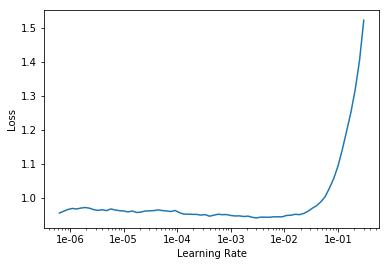

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(6, max_lr=6e-4)

Total time: 4:27:19
epoch  train_loss  valid_loss  accuracy  map3    
1      0.813238    0.732632    0.780824  0.850588  (44:32)
2      0.719399    0.658892    0.802059  0.867490  (44:34)
3      0.632875    0.596145    0.819471  0.880000  (44:33)
4      0.537060    0.564679    0.831588  0.888971  (44:32)
5      0.449523    0.540408    0.839529  0.894725  (44:32)
6      0.372626    0.553829    0.838294  0.893784  (44:33)



In [30]:
learn.save(f'{name}-stage-2')

In [ ]:
learn.load(f'{name}-stage-2');

In [31]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [32]:
top_3 = np.argsort(preds.numpy())[:, ::-1][:, :3]

In [33]:
labels = []
for i in range(top_3.shape[0]):
    labels.append(' '.join([learn.data.train_ds.classes[idx] for idx in top_3[i]]))

In [34]:
labels[1]

'pants shorts underwear'

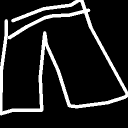

In [35]:
test_dl.dataset[1][0]

In [36]:
key_ids = [path.stem.split('_')[1] for path in learn.data.test_dl.dl.dataset.x]

In [37]:
os.makedirs(f'subs', exist_ok=True)
sub = pd.DataFrame({'key_id': key_ids, 'word': labels})
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [38]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9413660627454708,horse zebra cow
1,9738540686991405,pants shorts underwear
2,9865207604494741,knee leg elbow
3,9581975421394765,sweater jacket t-shirt
4,9721368529374760,mug cup coffee_cup


In [39]:
#!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|███████████████████████████████████████| 1.50M/1.50M [00:06<00:00, 236kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge